<a href="https://colab.research.google.com/github/keng-oh/colab/blob/master/rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN


In [0]:
# 必要なライブラリを読み込み
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 不要な警告を非表示にする
import warnings
warnings.filterwarnings('ignore')

In [0]:
# データセットのダウンロード
from urllib import request

url = 'http://dv129ryj03col.cloudfront.net/international-airline-passengers.csv'
request.urlretrieve(url, 'international-airline-passengers.csv')

('international-airline-passengers.csv',
 <http.client.HTTPMessage at 0x7f200d697358>)

In [0]:
# csvファイルを読み込み、データフレーム形式で表示
df = pd.read_csv('./international-airline-passengers.csv')  # クオーテーションの中は、csvファイルが置いてある場所を各自指定してください

In [0]:
# データの最初の5行を表示
df.head()

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [0]:
# データの後ろの5行を表示
df.tail()

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0
144,International airline passengers: monthly tota...,NaN


In [0]:
# 最後のサンプルを観察
print(df.iloc[144])

Month                                                                             International airline passengers: monthly tota...
International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60                                                  NaN
Name: 144, dtype: object


In [0]:
# 乗客数のカラム名を変更
df.columns = ['Month', 'Passengers']

# 最後の行以外を選択
df = df.iloc[:-1]

# 整形したデータを確認
df.tail()

,Month,Passengers
139,1960-08,606.0
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0


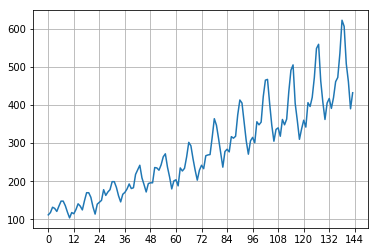

In [0]:
# データの可視化
plt.plot(df['Passengers'])
plt.xticks(np.arange(0, 145, 12)) # 12ヶ月ごとにグリッド線を表示
plt.grid()
plt.show()

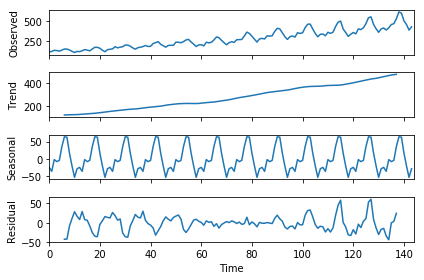

In [0]:
# 3つの成分に分解
from statsmodels.tsa.seasonal import seasonal_decompose
sd = seasonal_decompose(df['Passengers'].values, freq=12) # fleqで何ヶ月周期かを指定
sd.plot()
plt.show()

In [0]:
# データKerasが扱える型に変換
data = df['Passengers'].values.astype('f')

# 大きさを0から1に正規化（この処理をしないとうまく学習できない）
scale = data.max()
data /= scale

In [0]:
# 最初と最後のサンプルをひとつずつ削る
X = data[:-1]
y = data[1:]

In [0]:
# 系列の要素数を確認
# 144からひとつずつ減って､143になっている
print('X:',len(X))
print('y:', len(y))

X: 143
y: 143


In [0]:
# X, yのサイズ確認
print('X:', np.shape(X), ' y:', np.shape(y))

X: (143,)  y: (143,)


In [0]:
# Kerasの時系列解析用にshapeを変換
X = X.reshape(len(X), 1, 1)
y = y.reshape(len(y), 1)

In [0]:
# X, yのサイズ確認
print('X:', np.shape(X), ' y:', np.shape(y))

X: (143, 1, 1)  y: (143, 1)


In [0]:
# 訓練データのサンプル数を指定
train_size = int(len(data) * 0.7)
print(train_size)

100


In [0]:
# データの分割
X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

In [0]:
# shapeを確認
print('X_train:', X_train.shape)
print('X_test :', X_test.shape)
print('y_train:', y_train.shape)
print('y_test :', y_test.shape)

X_train: (100, 1, 1)
X_test : (43, 1, 1)
y_train: (100, 1)
y_test : (43, 1)


In [0]:
# モジュールのインポート

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM
from keras.optimizers import Adam
import tensorflow as tf

In [0]:
# モデルの定義
model = Sequential()
model.add(LSTM(30, batch_input_shape=(None, 1, 1))) # 中間層が30のLSTM
model.add(Dense(1)) # 回帰なので最後の出力値は１つ

#コンパイル
model.compile(loss='mean_squared_error', optimizer=Adam()) # 回帰なので損失関数に誤差二乗和を用いる

# ミニバッチに含まれるサンプル数を指定
batch_size = 20

# epoch数を指定
n_epoch = 200

In [0]:
# モデルの確認
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 30)                3840      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 31        
Total params: 3,871
Trainable params: 3,871
Non-trainable params: 0
_________________________________________________________________


In [0]:
# 学習開始
hist = model.fit(X_train,
                 y_train,
                 epochs=n_epoch,
                 validation_data=(X_test, y_test),
                 verbose=0,
                 batch_size=batch_size)

W0627 15:14:23.064655 139776757086080 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0627 15:14:23.559630 139776757086080 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0627 15:14:23.644047 139776757086080 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



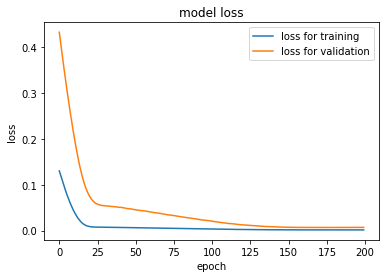

In [0]:
def plot_history_loss(hist):
    # 損失値(Loss)の遷移のプロット
    plt.plot(hist.history['loss'],label="loss for training")
    plt.plot(hist.history['val_loss'],label="loss for validation")
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='best')
    plt.show()


plot_history_loss(hist)

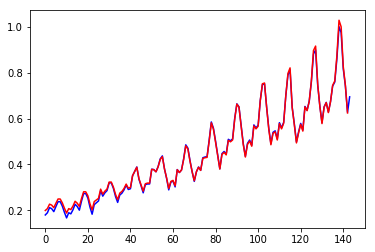

In [0]:
y_pred = model.predict(X)

# プロット
plt.plot(data, color='blue')  # 実測値
plt.plot(y_pred, color='red')   # 予測値
plt.show()

In [0]:
# 出力の正規化を戻す関数
def pred_n_passengers(y_pred, scale, year, month):
    index = ((year - 1949) * 12) + (month - 1)
    return y_pred[index] * scale
# 試しに､1950年4月の乗客数を予測
print(pred_n_passengers(y_pred, scale, 1950, 4))

[143.8841]
